In [1]:
import sys
sys.path.append('modules/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from importlib import reload
sns.set_style('white')
from importlib import reload
import logomaker
from Bio import motifs as mots
import glob
import matplotlib
import figures as fg
import general as gn
from itertools import repeat
import math
import matplotlib as mpl
import statsmodels.api as sm
import scikit_posthocs as sp
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scipy
from collections import defaultdict

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Load all the data, filter, rename, and bin

In [3]:
data = pd.read_pickle('data/averaged_chec_sumprom.gz')
TFS = ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3', 'Gln3', 'Rpn4']

gp = pd.read_csv('data/geneinfo_params.csv', index_col=0)
aro_targets = np.array([1302,6541,4730,4729,2603,2604])
aro_targets = gp.iloc[aro_targets-1].index
data_check = data.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_waro = data
data_waro = data_waro.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})

data_check = data.drop(aro_targets)

nuc_df = pd.read_csv('data/nucleosomes_df_perprom700bp.csv', index_col=0)
rna_nonlibs = pd.read_pickle('data/all_nonlibs_rna_samles.gz')
rna_libs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0)
facs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0).loc['facs']
by_rna = pd.read_csv('data/by_ultimate_61samples.csv', index_col=0)
by_rna_median = pd.DataFrame(by_rna.median(axis=1), columns=['BY_61_med'])

# Binning and filtering genes
all_dat = pd.concat([rna_libs.drop('facs'), rna_nonlibs], axis=1)
gene_thresh = 4.5
strain_thsh = 0.025
for_binnning = ((all_dat > gene_thresh).sum(axis=1) > all_dat.shape[1] * strain_thsh).values
bins = pd.qcut(by_rna_median.loc[for_binnning, 'BY_61_med'], q=10, labels=False, duplicates='drop')
data_waro = data_waro.loc[bins.drop('MNASE').index]


#Looking only on relevant genes
rna_nonlibs = rna_nonlibs.loc[bins.index]
rna_libs = rna_libs.loc[bins.index]
by_rna_median = by_rna_median.loc[bins.index]
rna_libs = pd.concat([rna_libs,pd.DataFrame(facs).transpose()], axis=0)
data_check = data_check.loc[bins.drop(['MNASE', 'SPL2', 'NAF1', 'ESBP6', 'SDH6']).index]

rna_libs.columns = [name.replace('Parent', 'nativeprom') for name in rna_libs.columns.values]
facs.index = [name.replace('Parent', 'nativeprom') for name in facs.index.values]


# opn = pd.read_csv('data/external_datasets/opn_score.csv', index_col=0)
opn = pd.read_csv('data/external_datasets/opn_mine.csv', index_col=0)
opn.loc[np.isinf(opn.loc[:, 'opn_score']).values, 'opn_score'] = math.nan

pseudocounts={'A':1-0.3829736683443062, 'C': 0.3829736683443062, 'G': 0.3829736683443062, 'T': 1-0.3829736683443062}
background={'A':(1-0.3829736683443062)/2, 'C': 0.3829736683443062/2, 'G': 0.3829736683443062/2, 'T': (1-0.3829736683443062)/2}

In [4]:
sagie_dat2= pd.read_csv('data/external_datasets/tfs_sumprom.csv')
sagie_dat2.index=gp.index
sagie_dat2 = sagie_dat2.loc[data_waro.index]
gal11_lab_dat = pd.DataFrame(sagie_dat2.loc[:, 'Gal11'])

newdat = pd.read_pickle('data/sumprom_20230328_last_one.gz')
med15newdat = newdat.filter(regex='Med15')
med15newdat.columns = [name[:-2] for name in med15newdat.columns.values]
med15newdat = med15newdat.transpose().reset_index().groupby('index').mean().transpose()
med15newdat.columns.name = None
med15newdat.columns = [name.split('_')[-1].capitalize().replace('gal4ad', 'Gal4AD').replace('gcn4ad', 'Gcn4AD')+'_med15mnase' for name in med15newdat.columns.values]
med15newdat = med15newdat.loc[bins.index[:-1]]
gal11_lab_dat = med15newdat.Native_med15mnase

In [5]:
thresh = 3
reload(fg)

binding_gcn4, rna_gcn4, top50_gcn4, fam_gcn4, wt_gcn4 = fg.get_data('Gcn4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_gal4, rna_gal4, top50_gal4, fam_gal4, wt_gal4 = fg.get_data('Gal4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_yap1, rna_yap1, top50_yap1, fam_yap1, wt_yap1 = fg.get_data('Yap1', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_msn2, rna_msn2, top50_msn2, fam_msn2, wt_msn2 = fg.get_data('Msn2', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_mig3, rna_mig3, top50_mig3, fam_mig3, wt_mig3 = fg.get_data('Mig3', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)



cmap = matplotlib.cm.get_cmap('YlOrRd')
tops = {'Msn2':top50_msn2, 'Gal4':top50_gal4, 'Gcn4':top50_gcn4, 'Mig3':top50_mig3, 'Yap1':top50_yap1}
individuals = {'Msn2':['TPS2', 'HOR7'], 'Gal4':['GAL10', 'GAL7'], 'Gcn4':['ARG56', 'CPA2'], 'Mig3':['HXT2', 'MIG2'], 'Yap1':['TRX2', 'YDL124W']}
wts = {'Msn2':wt_msn2, 'Gal4':wt_gal4, 'Gcn4':wt_gcn4, 'Mig3':wt_mig3, 'Yap1':wt_yap1}

all_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Abf1',
 'Crz1',
 'Gln3',
 'Reb1',
 'Met31',
 'Rpn4',
 'Sko1',
 'Cst6']



In [6]:

lab_dat = data_waro.filter(regex='|'.join(TFS)).filter(regex='lab_data')
lab_dat = lab_dat.drop(lab_dat.filter(regex='dbd').columns, axis=1)
lab_dat = lab_dat.drop('Gal4_lab_data', axis=1)
lab_dat.loc[:, 'Gal4'] = data_check.filter(regex='^Gal4Full').filter(regex='erv')
lab_dat = lab_dat.rename({'Gcn4_lown_lab_data': 'Gcn4_lab_data'}, axis=1)

lab_dat.columns = [name.replace('_lab_data', '') for name in lab_dat.columns.values]

In [7]:
opn = opn.loc[data_waro.index]
opn_index = opn.query('opn_score>0').index
dpn_index = opn.query('opn_score<=0').index
gray_index = opn.drop(np.concatenate((opn_index, dpn_index))).index
opn_bins = pd.qcut(opn.loc[:, 'opn_score'].values, 5, retbins=False, labels=False)
opn.loc[:, 'bins'] = opn_bins
opn.loc[:, 'bins'] = opn.loc[:, 'bins'].fillna(5)

In [8]:
tfs_binding_deletions_tef = data_waro.filter(regex=''.join(['^{}|'.format(tf) for tf in ['Gcn4', 'Yap1', 'Gal4', 'Mig3']])[:-1]).filter(regex='deletions')

tfs_binding_deletions_tef = pd.concat([ tfs_binding_deletions_tef.filter(regex='Gal4AD'),
                                      tfs_binding_deletions_tef.filter(regex='Gcn4AD'),
                                       tfs_binding_deletions_tef.filter(regex='Full'),
                                     ], axis=1)
gal11_dat = pd.concat([tfs_binding_deletions_tef,
                       gal11_lab_dat,
                       data_waro.filter(regex='DBDGal11'),
                       ], axis=1)
corr_dat = gal11_dat.copy()
corr_dat.columns = ['_'.join(name.split('_')[:2]) for name in gal11_dat.columns.values]

tefc = rna_libs.filter(regex='^Gal4|^Gcn4').filter(regex='TEF').columns.values
needed = corr_dat.filter(regex='^{}'.format('|^'.join(['Gcn4', 'Yap1', 'Gal4', 'Mig3'])))

# Funcs


In [11]:
def get_stats_anddata(curr_fc, dbdgal11_gal11ts, dbdgal11_only,toprint=False):
    res = scipy.stats.f_oneway(curr_fc.drop(list(dbdgal11_gal11ts)+list(dbdgal11_only)),
                            curr_fc.loc[dbdgal11_gal11ts],
                           curr_fc.loc[dbdgal11_only])[1]
    concat_fcs = np.concatenate((curr_fc.drop(list(dbdgal11_gal11ts)+list(dbdgal11_only)).transpose().values[0],
                                curr_fc.loc[dbdgal11_gal11ts].transpose().values[0],
                               curr_fc.loc[dbdgal11_only].transpose().values[0]))
    groups = [['background'] * curr_fc.drop(list(dbdgal11_gal11ts)+list(dbdgal11_only)).shape[0],
                  ['dbd-med15'] * curr_fc.loc[dbdgal11_gal11ts].shape[0],
                  ['dbds'] * curr_fc.loc[dbdgal11_only].shape[0]]
    
    a = sm.stats.multicomp.pairwise_tukeyhsd(concat_fcs, np.concatenate(groups))
    if toprint:
        print(a.summary())
    
    perc_affdbdgal11gal11 = np.round(((curr_fc.loc[dbdgal11_gal11ts]>=2).sum() / dbdgal11_gal11ts.shape[0]).values[0]*100, 3)
    perc_affdbdgal11only = np.round(((curr_fc.loc[dbdgal11_only]>=2).sum() / dbdgal11_only.shape[0]).values[0]*100,3)
    
    return perc_affdbdgal11gal11,perc_affdbdgal11only



def plot_venns(tf, curr_gal11_ts, dbdgal11_only, curr_fc, perc_affdbdgal11only,perc_itself,fig):
    ax = fig.subplots(2,2, sharex=True, sharey=True)
    ax=ax.flatten()
    sns.kdeplot(curr_fc.drop(dbdgal11_only).transpose().values[0], ax=ax[0], color='gainsboro',
                legend=False, fill=True, alpha=1, edgecolor='k')
    if tf != 'Rpn4aa':
        sns.kdeplot(curr_fc.loc[dbdgal11_only].transpose().values[0], ax=ax[2],
                    color='#F28705', legend=False, fill=True, alpha=0.6, edgecolor='k')
    else:
        ax[2].scatter(curr_fc.loc[dbdgal11_only].transpose().values[0], np.zeros(dbdgal11_only.shape[0])+ 0.025,
                     marker='|',c='#F28705', s=900,  edgecolor='k')
    
    sns.kdeplot(curr_fc.drop(curr_gal11_ts).transpose().values[0], ax=ax[1],
                color='gainsboro', legend=False, fill=True, alpha=1, edgecolor='k')
    sns.kdeplot(curr_fc.loc[curr_gal11_ts].transpose().values[0], ax=ax[3],
                color='#F28705', legend=False, fill=True, alpha=0.6, edgecolor='k')
    
    sns.despine(fig, left=True)
    for axi in ax.flatten():
        rect = axi.patch
        rect.set_alpha(0)
        axi.set_yticklabels('')
        axi.set_ylabel('')
    ax.flatten()[2].axvline(2, c='k')

    ax.flatten()[-1].axvline(2, c='k')
    fig.suptitle('Expression change distribution in {}-Med15 fusion'.format(tf))
    ax[0].text(-7.5,0.01,'background',fontweight="bold",fontsize=8,ha="center")
    ax[2].text(-7.5,0.01,'targets of dbds',fontweight="bold",fontsize=8,ha="center")
    ax[2].text(8,0.01,'{}% induced \nout of {}'.format(perc_affdbdgal11only, len(dbdgal11_only)),fontweight="bold",fontsize=8,ha="center")
    
    ax[1].text(-7.5,0.01,'background',fontweight="bold",fontsize=8,ha="center")
    ax[3].text(-7.5,0.01,'targets of dbd-med15',fontweight="bold",fontsize=8,ha="center")
    ax[3].text(8,0.01,'{}% induced \nout of {}'.format(perc_itself, len(curr_gal11_ts)),fontweight="bold",fontsize=8,ha="center")

    fig.subplots_adjust(hspace=-0.9, wspace=.3)
    return fig
ind_dd = lambda x: pd.Index(np.concatenate(x)).drop_duplicates()


# Fig. 5D

<AxesSubplot: >

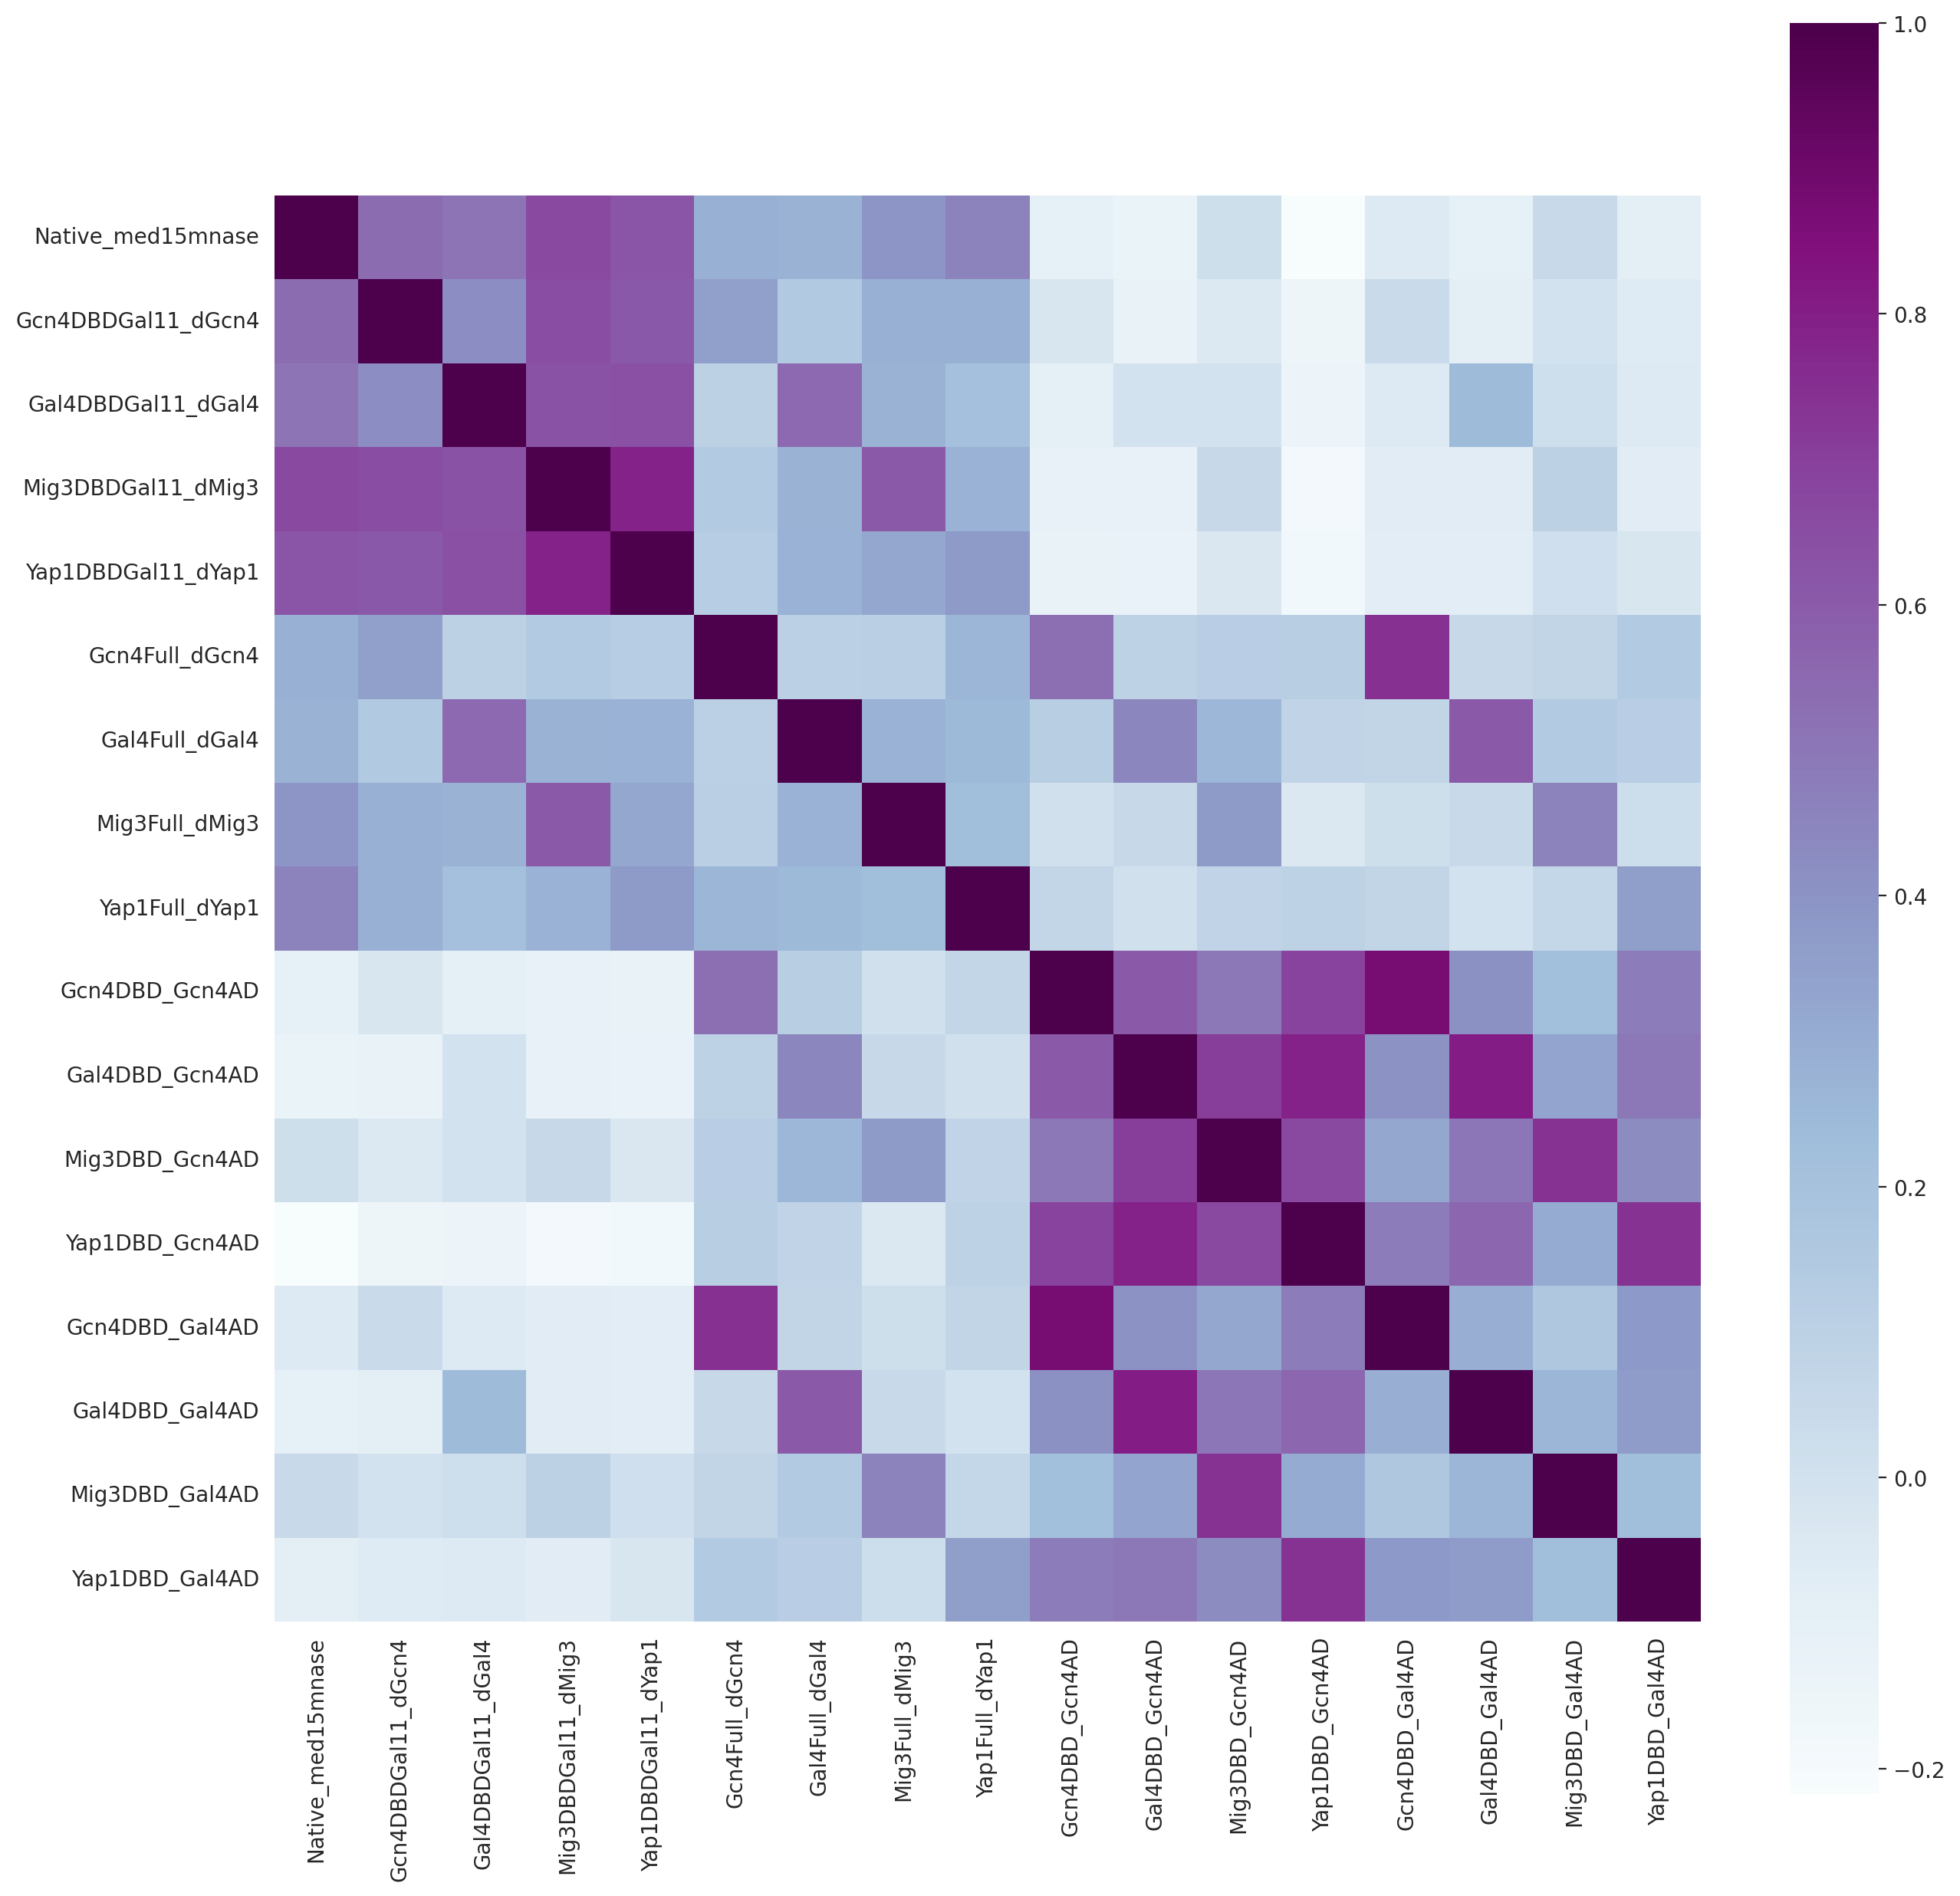

In [12]:
fig, ax = plt.subplots(1, figsize=(15,15))
sns.heatmap(pd.concat([gal11_lab_dat, needed.loc[:, needed.columns[::-1]]], axis=1).corr(), ax=ax, cmap='BuPu', square=True)
    
# fig.savefig('after_gm/fig6/corrs.pdf', bbox_inches = 'tight')

# Fig. 5B, F

In [13]:
tfs_binding_deletions_tef = data_waro.filter(regex=''.join(['^{}|'.format(tf) for tf in ['Gcn4', 'Yap1', 'Gal4', 'Mig3', 'Rpn4']])[:-1]).filter(regex='deletions')

tfs_binding_deletions_tef = pd.concat([ tfs_binding_deletions_tef.filter(regex='Full'),
                                       tfs_binding_deletions_tef.filter(regex='Gal4AD'),
                                      tfs_binding_deletions_tef.filter(regex='Gcn4AD'),
                                       
                                     ], axis=1)
gal11_dat = pd.concat([tfs_binding_deletions_tef,
                       gal11_lab_dat,
                       data_waro.filter(regex='DBDGal11'),
                       ], axis=1)

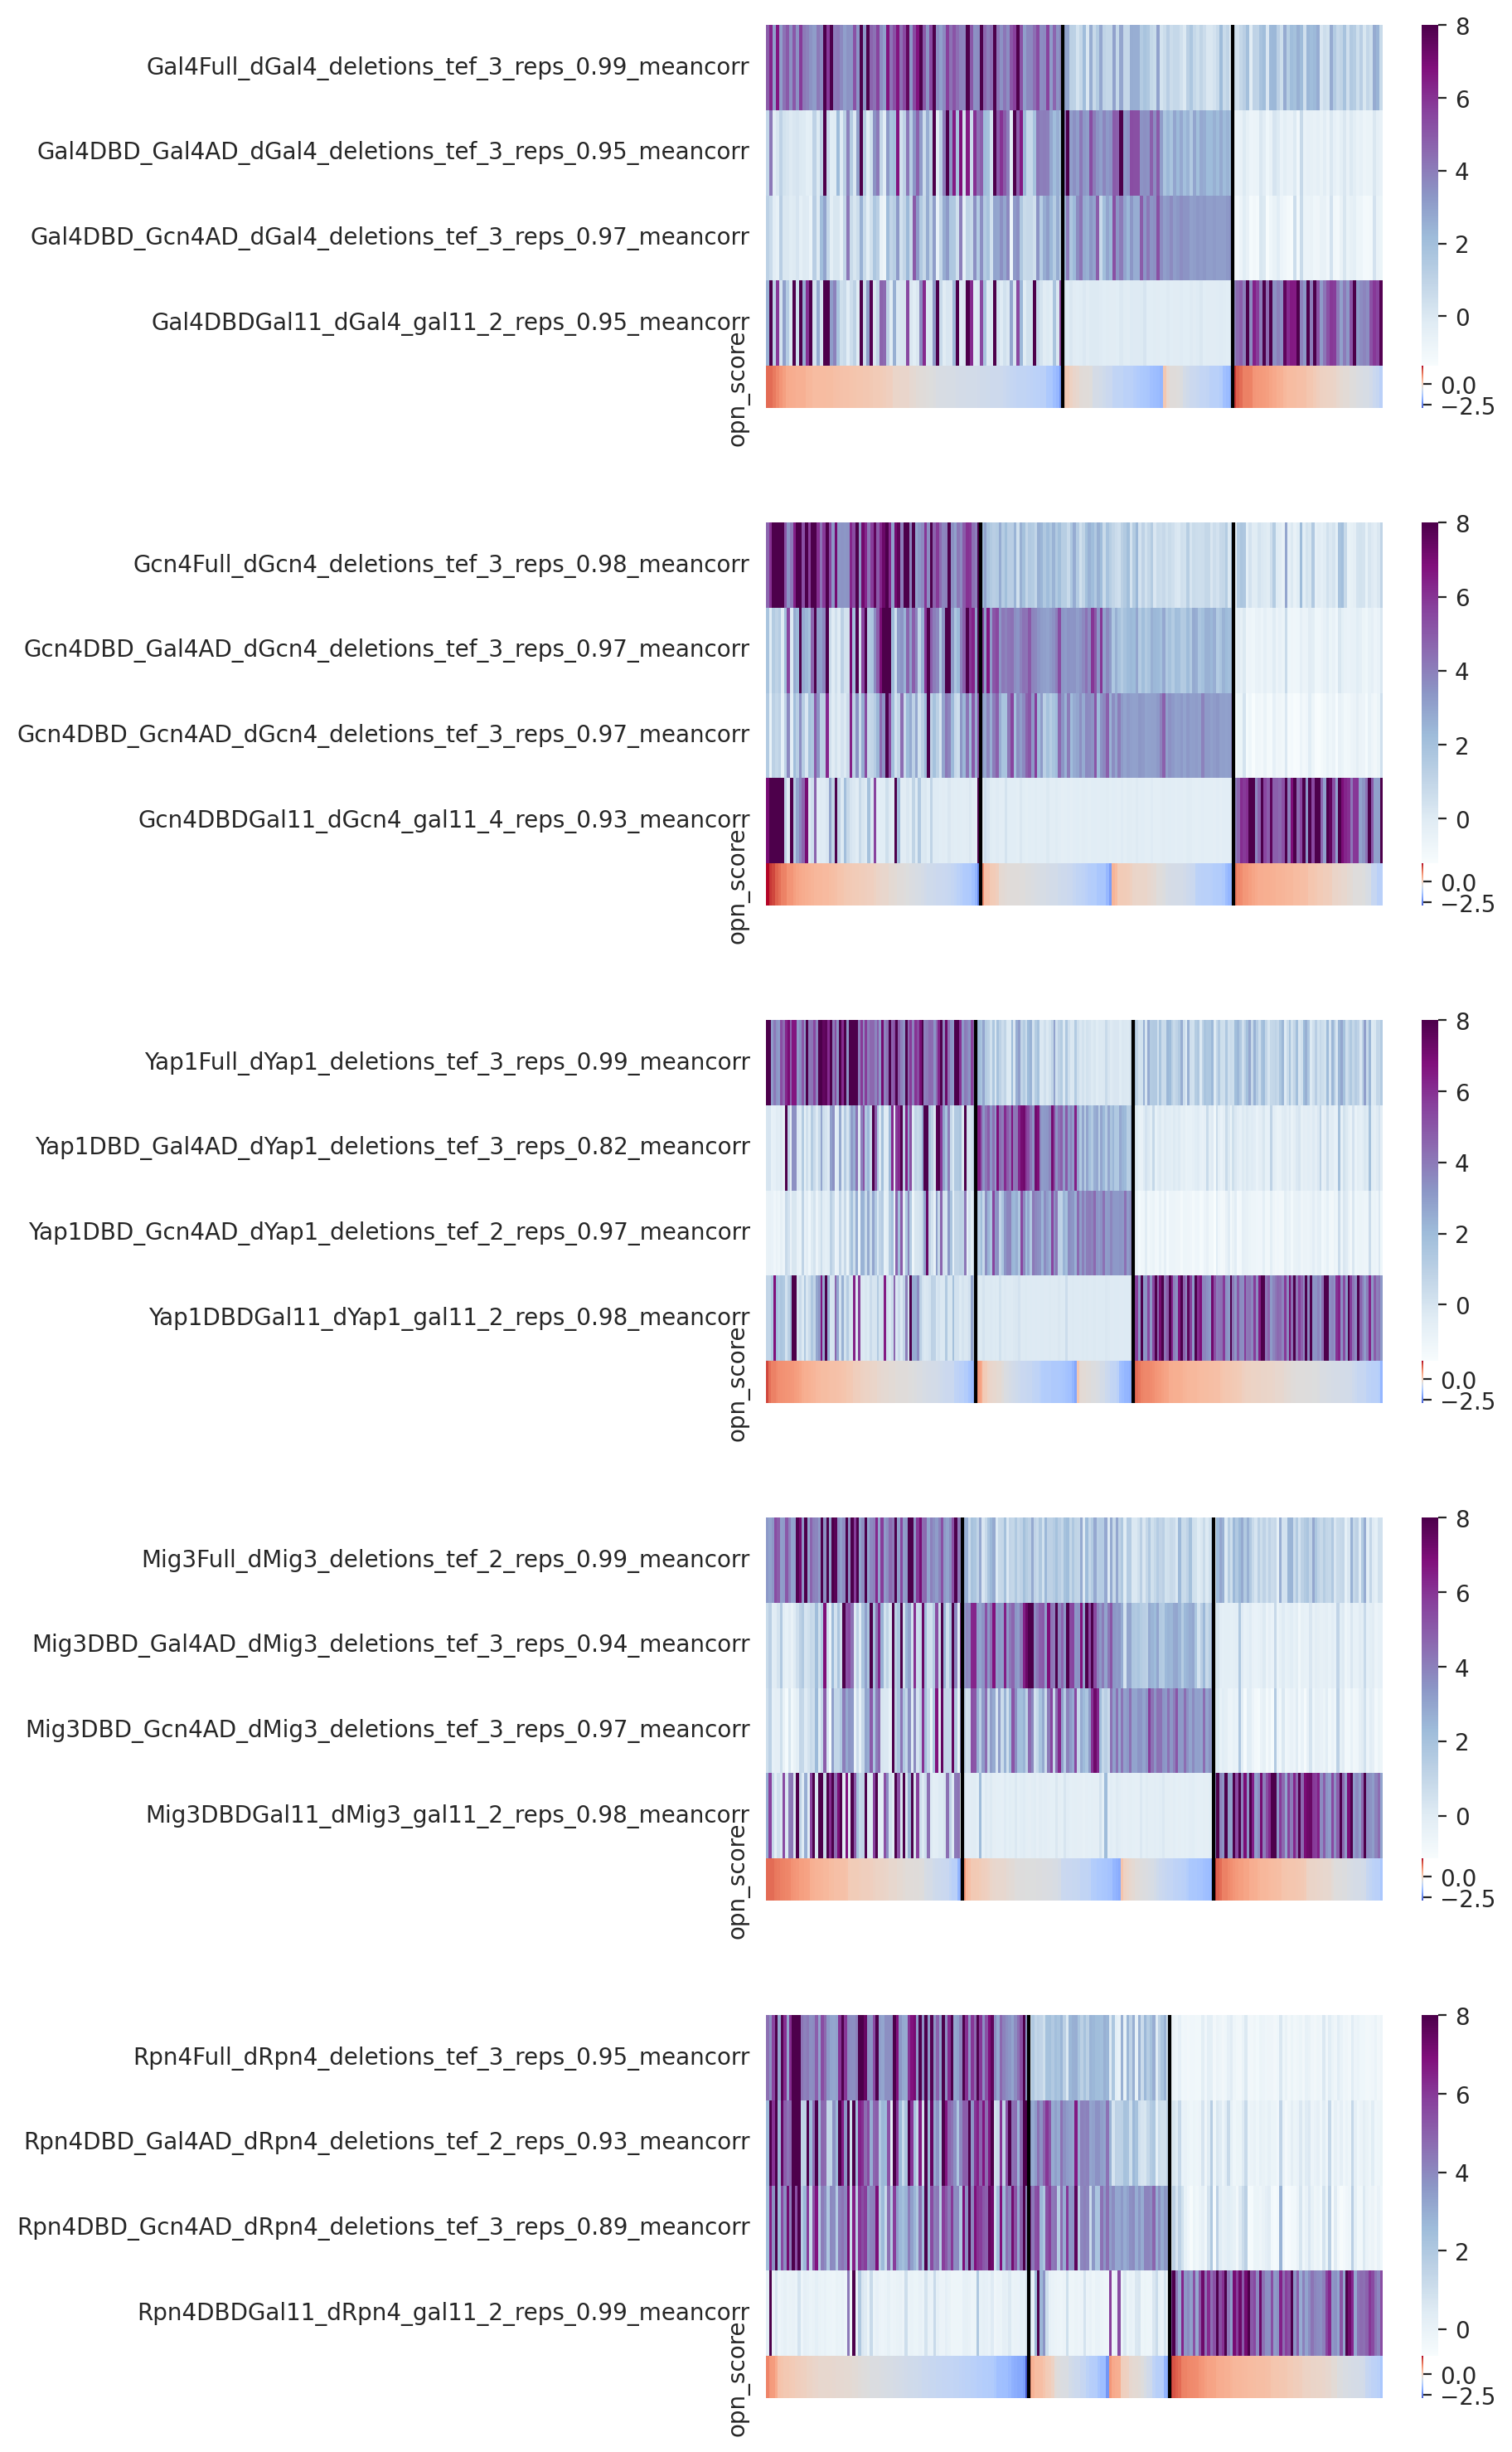

In [14]:
targets_df = fg.get_targets_df(gal11_dat, 3, 'new', opn, 'opn')
medts = fg.get_targets_df(pd.DataFrame(gal11_lab_dat.loc[bins.index[:-1]]),3,'med', opn.loc[bins.index[:-1]],'opn').iloc[0,0]

dbdmedts = list()
dbdmedzs = list()
dbdadtsmedzs = list()
dbdadtsdbdzs = list()
wttsmedzs = list()
medmedzs = list()

fig = plt.figure(figsize=(6,15))
subfigs = fig.subfigures(len(['Gal4', 'Gcn4', 'Yap1', 'Mig3', 'Rpn4']), 1,)
for k, tf in enumerate([ 'Gal4', 'Gcn4', 'Yap1', 'Mig3', 'Rpn4']):
    targets_df = fg.get_targets_df(gal11_dat.filter(regex='^{}'.format(tf)), 3, 'new', opn, 'opn')
    vector_ts = pd.Index(np.concatenate(np.concatenate(targets_df.values))).drop_duplicates()
    wt_ts = targets_df.iloc[0,0]
    
    dbd_ts1 = set(targets_df.iloc[1,0]).difference(wt_ts)
    dbd_ts2= set(targets_df.iloc[2,0]).difference(wt_ts)
    
    dbd_ts = set(list(dbd_ts1)+list(dbd_ts2))
    dat = gn.get_zscored(gal11_dat).filter(regex='^{}'.format(tf)).loc[vector_ts].copy()
    
    dbdmedts.extend(dat.loc[targets_df.iloc[-1,0]].index)
    dbdmedzs.extend(dat.loc[targets_df.iloc[-1,0]].iloc[:,-1].values)
    if tf !='Rpn4':
        dbdadtsmedzs.extend(dat.loc[dbd_ts].iloc[:,-1].values)
        wttsmedzs.extend(dat.loc[set(wt_ts).difference(medts)].iloc[:,-1].values)
        medmedzs.extend(gn.get_zscored(gal11_dat).filter(regex='^{}'.format(tf)).loc[medts].iloc[:,-1].values)
        dbdadtsdbdzs.extend(dat.loc[dbd_ts1].iloc[:, 1].values)
        dbdadtsdbdzs.extend(dat.loc[dbd_ts2].iloc[:, 2].values)

    
    ax = subfigs[k].subplots(2,1,height_ratios=[8,1])
    sns.heatmap(dat.transpose(),yticklabels=dat.columns,
                xticklabels=False, vmax=8, cmap='BuPu', ax=ax[0])
    sns.heatmap(pd.DataFrame(opn.loc[vector_ts, 'opn_score']).transpose(), ax=ax[1],
                xticklabels=False, cmap='coolwarm', center=opn.opn_score.mean(), vmax=opn.opn_score.max(), vmin=opn.opn_score.min())
    ax[0].axvline(wt_ts.shape[0], c='k')
    ax[0].axvline(wt_ts.shape[0]+len(dbd_ts), c='k')
    ax[1].axvline(wt_ts.shape[0], c='k')
    ax[1].axvline(wt_ts.shape[0]+len(dbd_ts), c='k')
fig.subplots_adjust(hspace=0)
# fig.savefig('after_gm/fig6/proms_fig.pdf', bbox_inches = 'tight')

# Fig. 5C

/tmp/ipykernel_263602/3381884997.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['DBD-AD newly acquired', 'WT no inters. with Med', 'Med15 native targets'])


Text(0, 0.5, 'DBD-Med15 binding zscore')

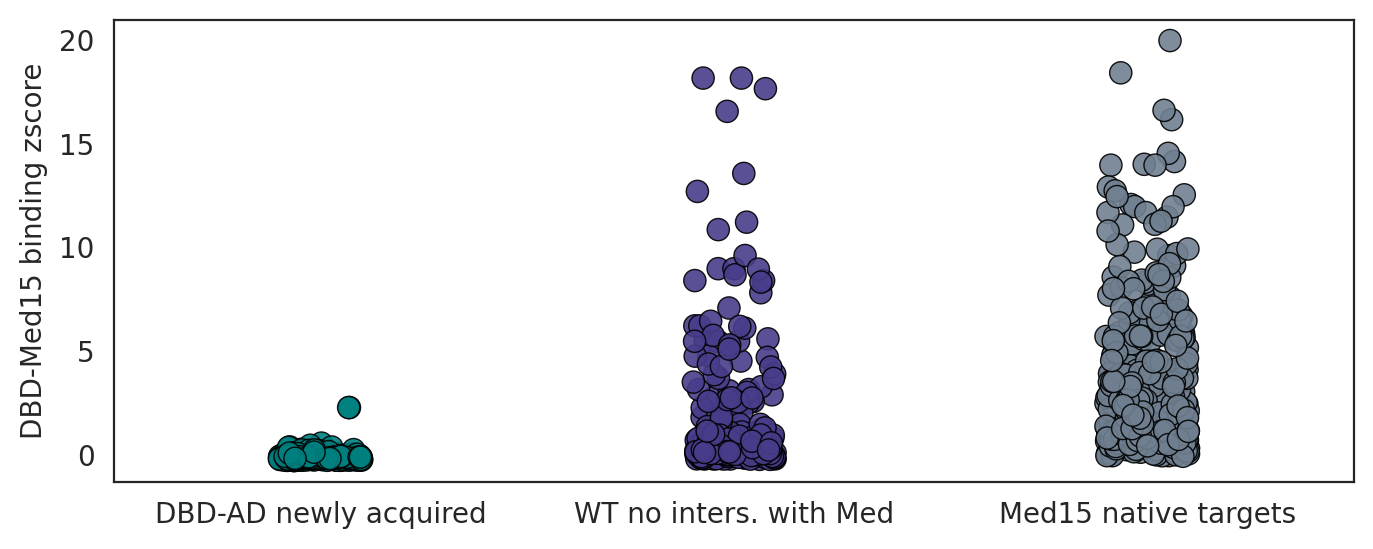

In [15]:
dbd_vs_med = pd.DataFrame({i:pd.Series(k) for i, k in enumerate([dbdadtsmedzs, wttsmedzs, medmedzs])})
dbd_vs_med.columns = [ 'dbd-med15 dbd targ', 'dbd-med15 wt targ.', 'medmed']

fig, ax = plt.subplots(1, figsize=(8,3))
sns.stripplot(dbd_vs_med, palette=['teal', 'darkslateblue', 'slategray'],ax=ax, size=8, edgecolor='k', linewidth=.5, alpha=.9)
ax.set_xticklabels(['DBD-AD newly acquired', 'WT no inters. with Med', 'Med15 native targets'])
ax.set_ylabel('DBD-Med15 binding zscore')
# fig.savefig('after_gm/fig6/med15_bindingclasses.pdf', bbox_inches = 'tight')

# Fig 5G

Text(0, 0.5, 'OPN score')

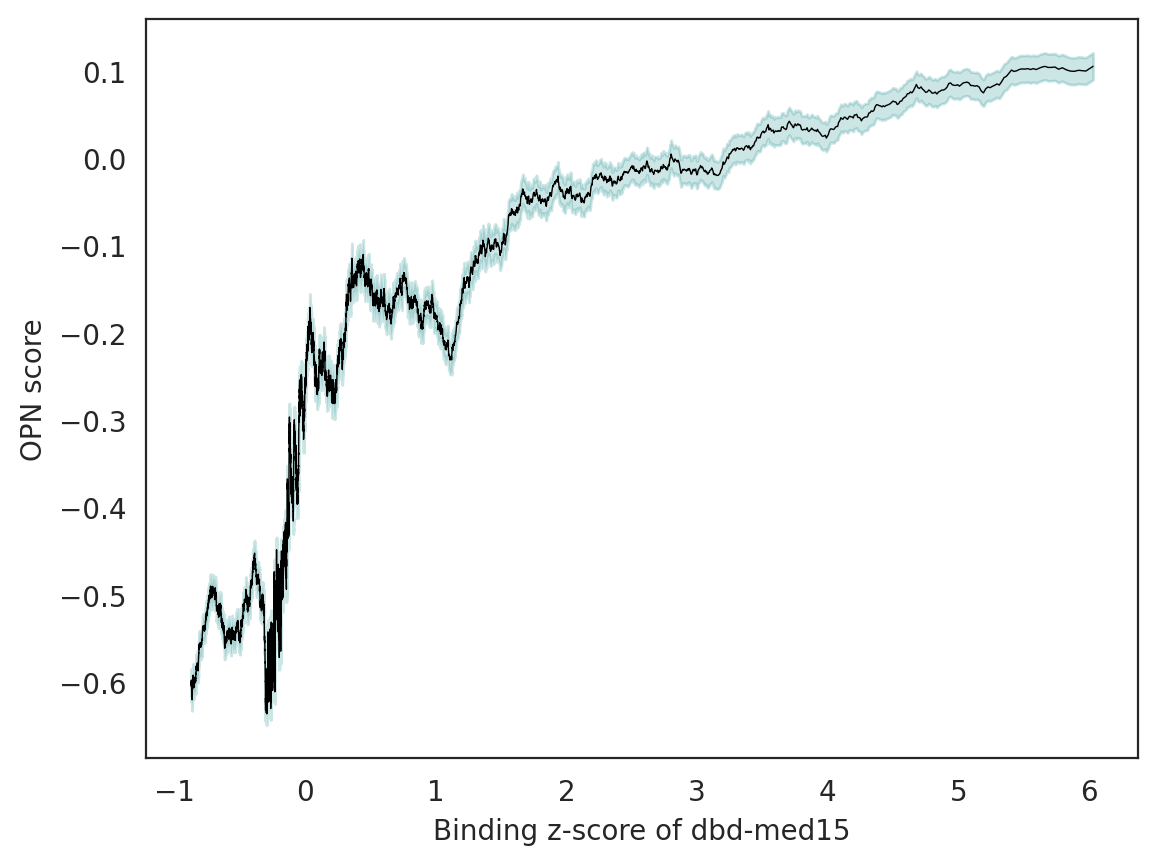

In [18]:
all_together = gn.get_zscored(gal11_dat).filter(regex='Gal11').unstack().reset_index()
all_together.index = all_together.name
all_together = all_together.drop(['name', 'level_0'], axis=1)
all_together.loc[:, 'opn'] = opn.opn_score.loc[all_together.index]
all_together.columns = ['zscore', 'opn']

d = all_together.sort_values(by='zscore').dropna().rolling(window=500).mean()
d_std= all_together.sort_values(by='zscore').dropna().rolling(window=500).sem()*0.5
lower = d - d_std
upper = d + d_std
fig, ax = plt.subplots(1)
ax.plot(d.zscore, d.opn,c='k', linewidth=.5, rasterized=False)
ax.fill_between(d.zscore, lower.opn, upper.opn, color='teal', alpha=.2, rasterized=True)
ax.set_xlabel('Binding z-score of dbd-med15')
ax.set_ylabel('OPN score')
# ax.set_xlim([3.3,11.1])
# fig.savefig('after_gm/fig6/opnvsmed_rast.pdf', bbox_inches = 'tight', dpi=1000)

# Fig 5A, E

In [19]:
bins_std = rna_nonlibs.groupby(bins).std()
bins_mean = rna_nonlibs.groupby(bins).mean()
get_zs = lambda x: rna_nonlibs.loc[bins[bins == x].index].sub(bins_mean.loc[x]).div(bins_std.loc[x])
zs_fc_alltfs = pd.concat(map(get_zs, range(10))).loc[data_waro.index]

zs_fc_alltfs.columns = ['_'.join(name.split('_')[:-1]) for name in zs_fc_alltfs.columns.values]
zs_fc_alltfs = zs_fc_alltfs.transpose().reset_index().groupby('index').mean().transpose().rename_axis(None, axis=1)
needed_fc = zs_fc_alltfs.filter(regex='DBDGal11')

fulltargets = fg.get_targets_df(tfs_binding_deletions_tef.filter(regex='Full'), 3, 'fulls', opn)
dbdtargets = fg.get_targets_df(tfs_binding_deletions_tef.filter(regex='DBD'), 3, 'fulls', opn)
gl11_ts = fg.get_targets_df(pd.DataFrame(gal11_lab_dat),3,'g', opn).iloc[0,0]

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2  meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
background dbd-med15    1.792  0.001  1.5374  2.0466   True
background      dbds  -0.1126 0.4653 -0.3356  0.1105  False
 dbd-med15      dbds  -1.9046  0.001 -2.2405 -1.5686   True
-----------------------------------------------------------
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2  meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
background dbd-med15   1.3928  0.001  1.2067  1.5788   True
background      dbds   -0.285 0.0192 -0.5327 -0.0373   True
 dbd-med15      dbds  -1.6777  0.001 -1.9848 -1.3706   True
-----------------------------------------------------------


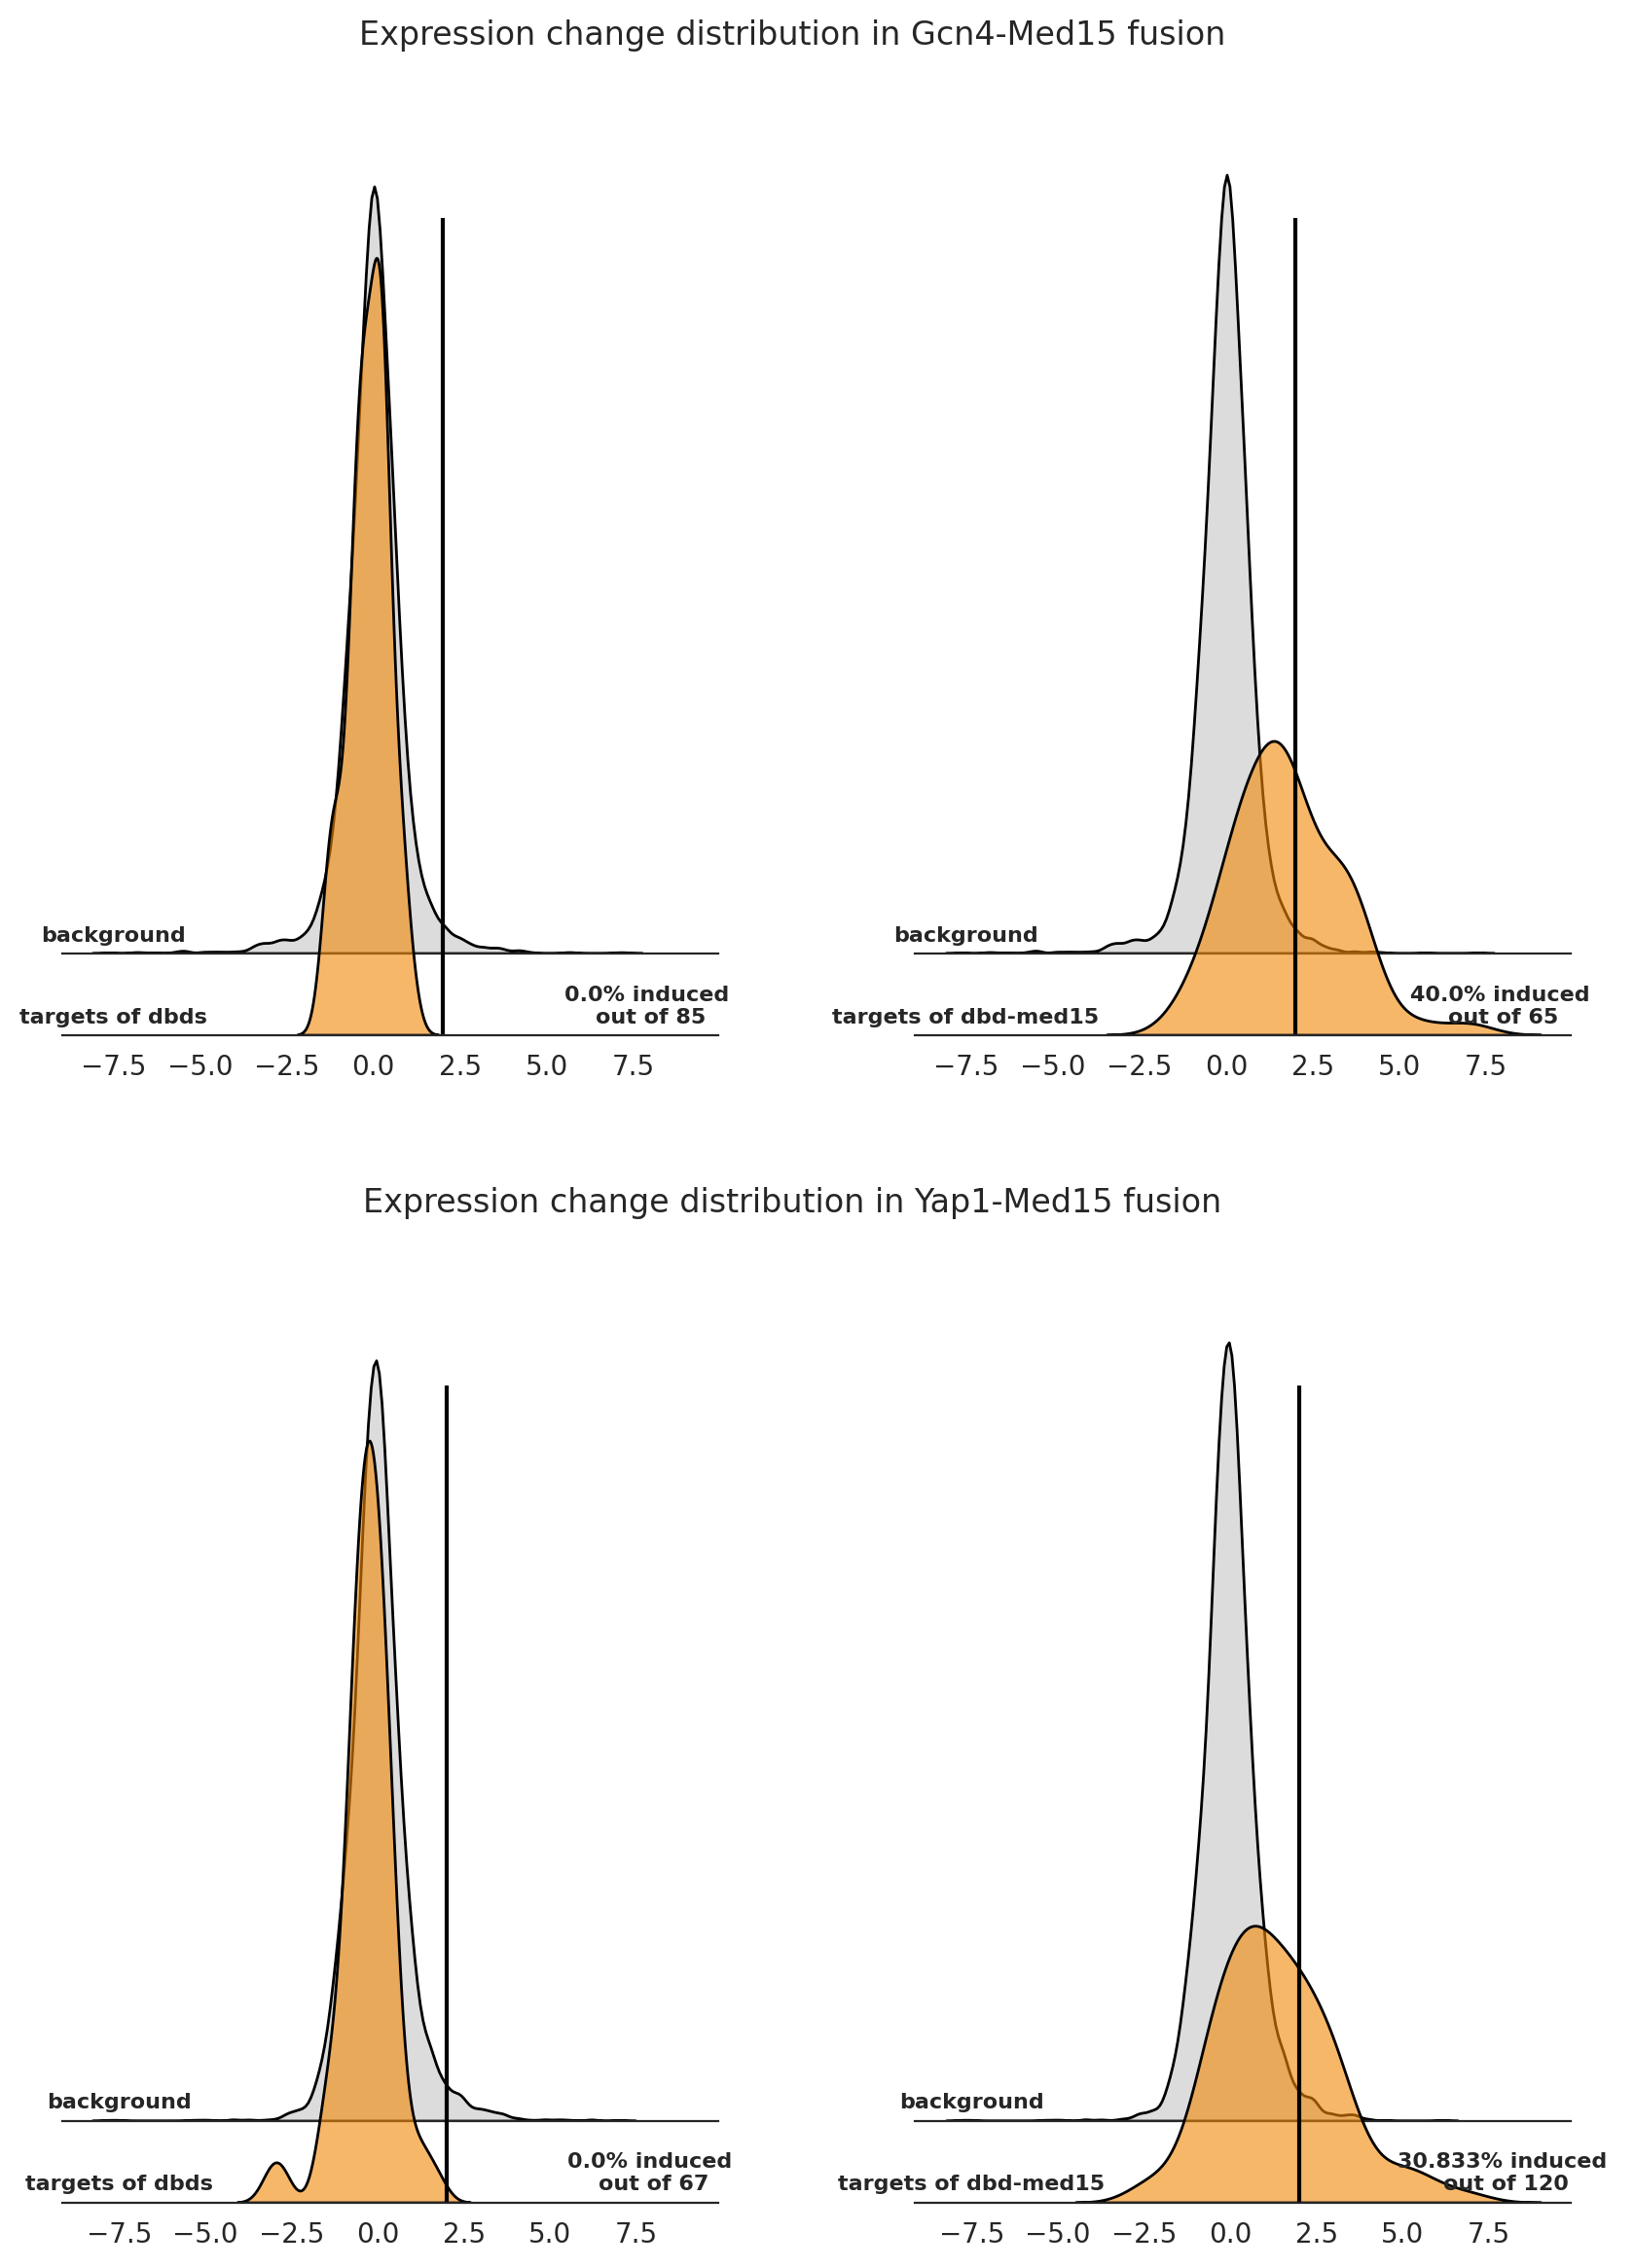

In [23]:
for_ht = []
fig = plt.figure(figsize=(10,12))
subfigs = fig.subfigures(2,1)
for tfi, tf in enumerate(['Gcn4', 'Yap1']):
    targets_df = fg.get_targets_df(gal11_dat.filter(regex='^{}'.format(tf)), 3, 'new', opn, 'opn')
    trial = gn.get_zscored(gal11_dat).filter(regex='^{}'.format(tf)).filter(regex='Gal11')
    curr_gal11_ts = targets_df.iloc[-1,0]
    curr_fc = needed_fc.filter(regex=tf)

    
    wt_ts = targets_df.iloc[0,0]
    
    dbd_ts1 = set(targets_df.iloc[1,0]).difference(wt_ts)
    dbd_ts2= set(targets_df.iloc[2,0]).difference(wt_ts)
    
    dbd_ts_to_anal = pd.Index((list(dbd_ts1)+list(dbd_ts2))).drop_duplicates()
    
    perc_affdbdgal11_itself, perc_affdbdgal11_dbd = get_stats_anddata(curr_fc, curr_gal11_ts, dbd_ts_to_anal, True)
    
    plot_venns(tf, curr_gal11_ts, dbd_ts_to_anal, curr_fc, perc_affdbdgal11_dbd, perc_affdbdgal11_itself, subfigs[tfi])
# fig.savefig('after_gm/fig6/expression_3together.pdf'.format(tf), bbox_inches = 'tight')

# Supp. fig. 9

Text(0, 0.5, 'Median OPN score')

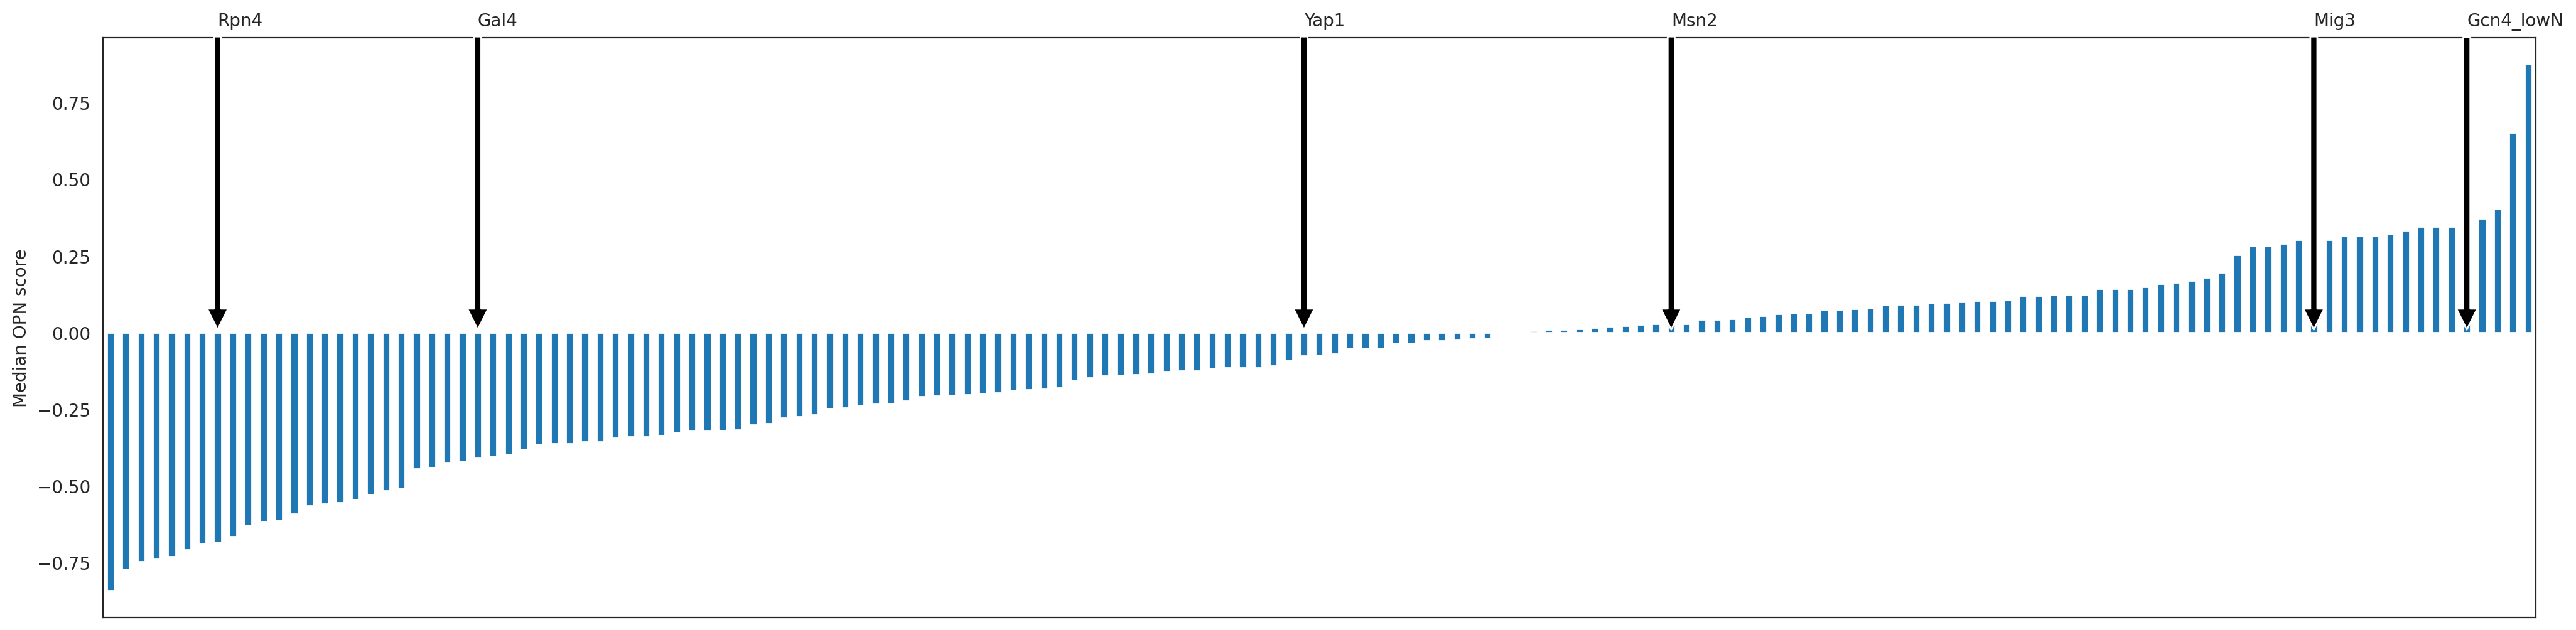

In [22]:
bartfs = ['Msn2', 'Gal4', 'Gcn4_lowN', 'Yap1', 'Mig3', 'Rpn4']

allll = fg.get_targets_df(sagie_dat2,3, 'all', opn, '')
opn_med = lambda x: opn.loc[x, 'opn_score'].median()
all_opn = allll.applymap(opn_med).drop(['Msn2_DBDOE', 'Msn2_DBD', 'Msn2nonDBD']).sort_values(by='all')
locs = [all_opn.index.get_loc(loc) for loc in bartfs ]

fig, ax =plt.subplots(1, figsize=(25,6))

all_opn.plot.bar(ax=ax)
ax.set_xticklabels('')
ax.legend_.remove()
for name, loc in zip(bartfs, locs):
    ax.annotate(name, (loc, 0), xytext=(loc, 1),arrowprops=dict(facecolor='black', shrink=0.01))
    
ax.set_ylabel('Median OPN score')

# fig.savefig('figures_finalized/supp/opn_all_factors.pdf', bbox_inches = 'tight')